# Ensemble learning

In [10]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [2]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [3]:
X = mnist.data[:1000]
y = mnist.target[:1000]

## 

In [4]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

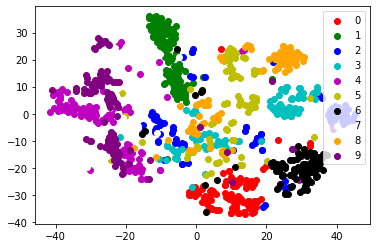

In [23]:
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
ids = [str(i) for i in range(10)]

for c, label in zip(colors, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.